## Task 1. Default Delay-Match-To-Sample (DMTS):
A sample image is presented and then, after a time delay of arbitrary duration, a test image is presented. The
goal is to evaluate the model's ability to retain the sample image in working memory during the delay period
and compare it to the test image. To titrate difficulty, the similarity between sample and test images can be
varied, and the model's invariance to image transformations and zero-shot generalization ability will also be
evaluated.


## Load packages etc

In [2]:
import tarfile
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

## 1. Loading of images


In [4]:
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']
def show_image(one_image):
    # Reshape the array to 32x32x3
    image = one_image.reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(image)
    plt.show()
def show_sequence(sequence, label):
    # sequence shape: [sequence_length, channels, height, width]
    # label shape: [1]

    fig, axs = plt.subplots(1, len(sequence), figsize=(15, 3))  # Adjust figsize as needed
    for i, img in enumerate(sequence):
        img = img.transpose(0, 2).transpose(0, 1)  # Convert to [height, width, channels]
        axs[i].imshow(img)
        axs[i].axis('off')  # Turn off axis

    plt.suptitle(f'Label: {label.item()}')
    plt.show()


In [7]:
raw_data = os.getcwd() + '/data/raw'
processed_data = os.getcwd() + '/data/processed'

# Unload the data into a target folder
with tarfile.open(raw_data + '/''cifar-10-python.tar.gz', 'r:gz') as tar:
    tar.extractall(path=processed_data)


In [9]:
# Iterate and load through all 6 batches, including the test data

training_images_cifar10 = {k: None for k in range(1,6)}
training_labels_cifar10 = {k: None for k in range(1,6)}

for ii in range(1,6):
    data, labels = load_cifar10_batch(processed_data + '/cifar-10-batches-py/data_batch_' + str(ii))
    training_images_cifar10[ii] = data
    training_labels_cifar10[ii] = labels

# Load the test data 
valid_images_cifar10, valid_labels_cifar10 = load_cifar10_batch(processed_data + '/cifar-10-batches-py/test_batch')

# Stack all the training data to have more data accessible
all_training_images_cifar10 = np.vstack([batch for batch in training_images_cifar10.values()])
all_training_labels_cifar10 = np.hstack([batch for batch in training_labels_cifar10.values()])

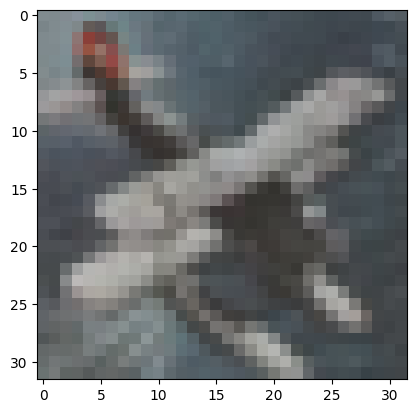

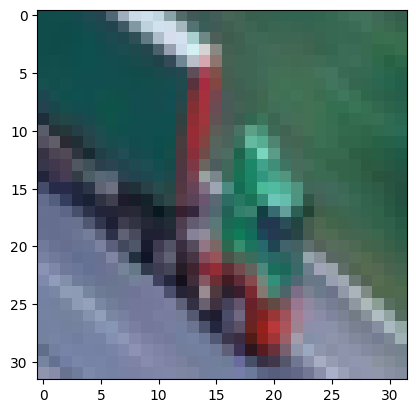

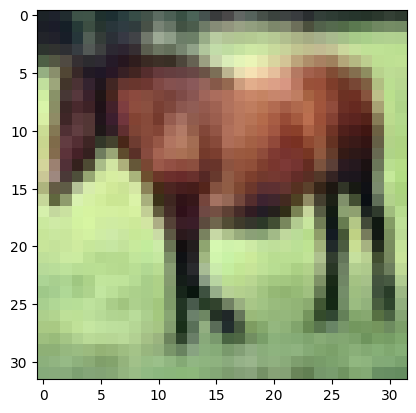

In [10]:
# Show an example of how the data looks like oka
show_image(all_training_images_cifar10[1012])
show_image(all_training_images_cifar10[50])
show_image(all_training_images_cifar10[7])

### Prepare the data for the DMTS task

The task needs to recognize if the sample and test image are the same. To this end, we need to preprocess and prepare our data.

In [11]:
class DMTSCIFAR10Dataset(Dataset):
    def __init__(self, data, labels, num_classes=10, delay_length=5, p=0.5, transform=None):
        # Initialize the dataset with CIFAR-10 data, labels, and transformation
        self.data = data
        self.labels = labels
        self.num_classes = num_classes
        self.delay_length = delay_length
        self.p = p
        self.transform = transform or transforms.ToTensor()
        self.empty_image = np.zeros((3, 32, 32), dtype=np.uint8)

    def __len__(self):
        # Length of the dataset is the number of images in CIFAR-10
        return len(self.labels)

    def __getitem__(self, idx):
        # Randomly choose whether the test image matches the sample
        match = random.random() < self.p
        sample_image = self.data[idx]
        sample_label = self.labels[idx]

        if match:
            # Choose the same image for the sample and test
            test_image = sample_image
        else:
            # Choose a different class for the test image
            different_class_images = [(img, lbl) for img, lbl in zip(self.data, self.labels) if lbl != sample_label]
            test_image, _ = random.choice(different_class_images)
        
        # Reshape and transform each image
        sample_image = self.transform(sample_image.reshape(3, 32, 32).transpose(1, 2, 0)) # (C, H, W)
        test_image = self.transform(test_image.reshape(3, 32, 32).transpose(1, 2, 0)) # (C, H, W)
        delay_images = [self.transform(self.empty_image.transpose(1, 2, 0)) for _ in range(self.delay_length)] # (C, H, W)

        # Stack the sequence [sample_image] + delay_images + [test_image]
        sequence = torch.stack([sample_image] + delay_images + [test_image], dim=0)  # Stack along a new axis

        # Label is 1 if images match, 0 otherwise
        label = torch.tensor([float(match)], dtype=torch.float32)

        return sequence, label

In [38]:
dmts_dataset_training = DMTSCIFAR10Dataset(data=training_images_cifar10[1], labels=training_labels_cifar10[1],
                                p = 0.5, delay_length = 5)

dmts_loader_training = DataLoader(dmts_dataset_training, batch_size=32, shuffle=True)

# Let's make a quick check to see if the data has been correctly formated
count = 0
limit = 5
for sequence, label in dmts_loader_training:
    print(sequence.shape)  # Should be [batch_size, sequence_length, channels, height, width]
                           # i.e. [batch_size, delay_length + 2, 3, 32, 32]
    print(label.shape)     # Should be [batch_size, 1]
    count+=1
    if count > limit:
        break  # Just to print the first batch's shapes

torch.Size([32, 7, 3, 32, 32])
torch.Size([32, 1])
torch.Size([32, 7, 3, 32, 32])
torch.Size([32, 1])
torch.Size([32, 7, 3, 32, 32])
torch.Size([32, 1])
torch.Size([32, 7, 3, 32, 32])
torch.Size([32, 1])
torch.Size([32, 7, 3, 32, 32])
torch.Size([32, 1])
torch.Size([32, 7, 3, 32, 32])
torch.Size([32, 1])


Now that the data is loaded in the correct format, let us plot it to see what is going to be fed into the model architecture

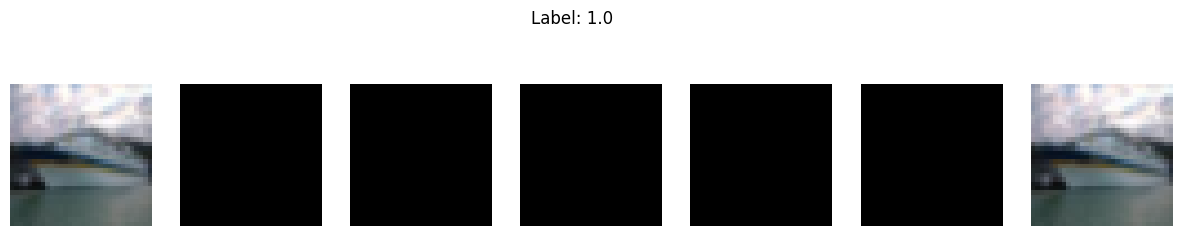

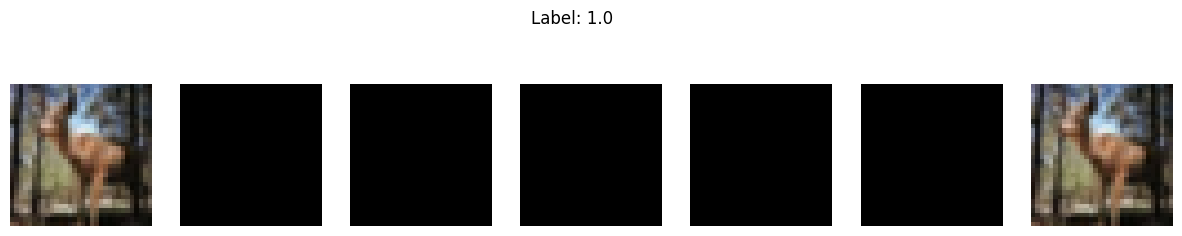

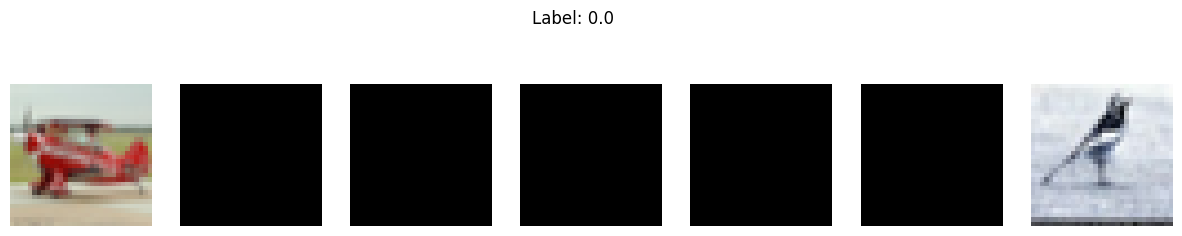

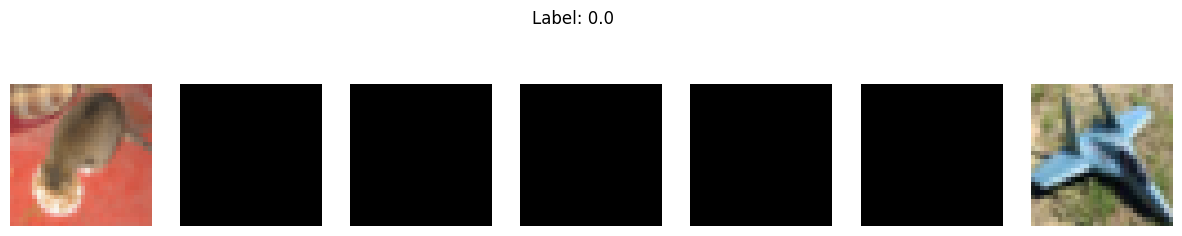

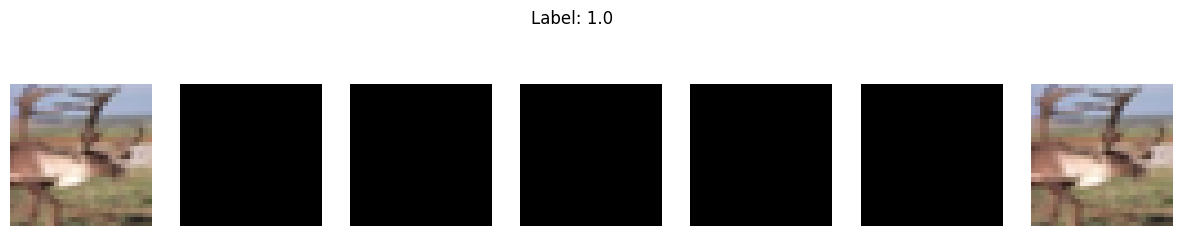

In [39]:
n_images_to_show = 5
for sequences, labels in dmts_loader_training:
    for i in range(n_images_to_show):  
        show_sequence(sequences[i], labels[i])
    break  # Only process the first batch

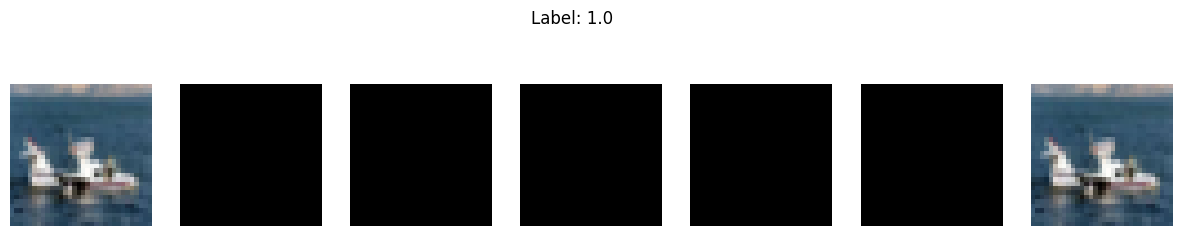

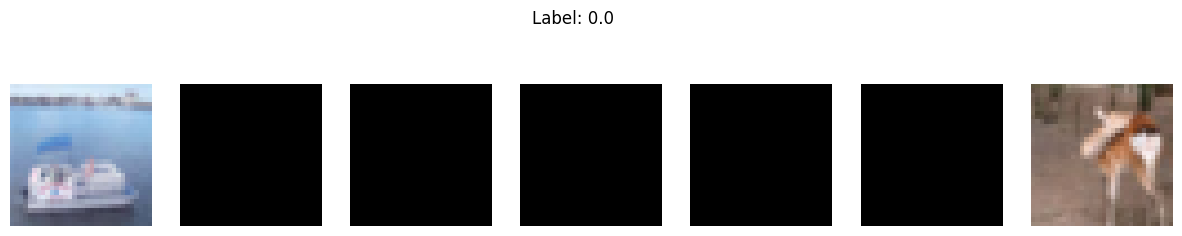

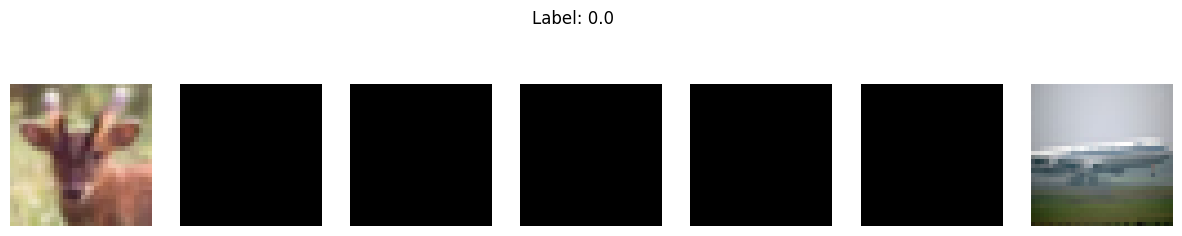

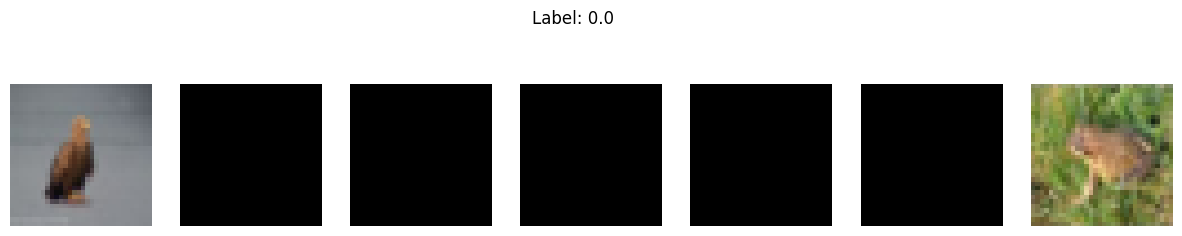

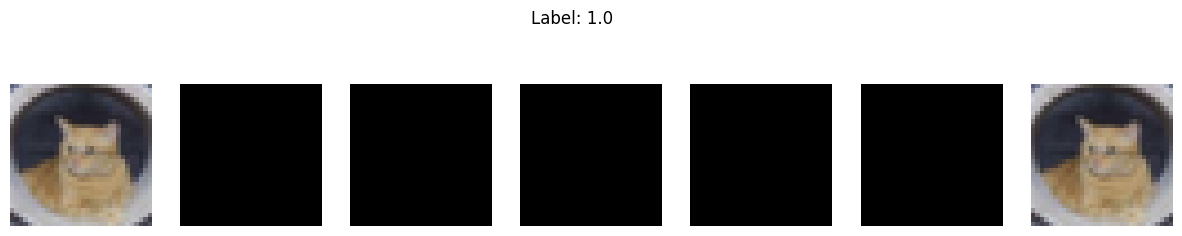

In [37]:
# Now produce the images for the validation set as well
dmts_dataset_valid = DMTSCIFAR10Dataset(data=valid_images_cifar10, labels=valid_labels_cifar10,
                                p = 0.5, delay_length = 5)

dmts_loader_valid = DataLoader(dmts_dataset_valid, batch_size=32, shuffle=True)

n_images_to_show = 5
for sequences, labels in dmts_loader_valid:
    for i in range(n_images_to_show):  
        show_sequence(sequences[i], labels[i])
    break  # Only process the first batch

## 2. Model design

Task 1 consists on a DMTS > Default delay-match to sample. To implement this, the following elements need to be included in the architecture:

- Recurrent Connectivity : to retain information over arbitrary periods
- CNN : feature extraction from images
- Adaptation for variable delay: need to handle a delay between sample and test images


In [40]:
class DMTSModel(nn.Module):
    def __init__(self, num_classes=1):
        # Num_classes 1 because this is a binary classification problem
        ####

        super(DMTSModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=64 * 8 * 8, hidden_size=128, batch_first=True)
        # Fully connected layer for classification
        self.fc = nn.Linear(in_features=128, out_features=num_classes)
        
    def forward(self, x):
        # x shape: (batch, time_steps, channels, height, width)
        batch_size, time_steps, C, H, W = x.size()
        # Flatten time steps into batch dimension
        c_in = x.view(batch_size * time_steps, C, H, W)
        # Convolutional layers with activation and pooling
        c_out = F.relu(F.max_pool2d(self.conv1(c_in), 2))
        c_out = F.relu(F.max_pool2d(self.conv2(c_out), 2))
        # Prepare output for LSTM
        r_in = c_out.view(batch_size, time_steps, -1)
        # LSTM layer
        r_out, (h_n, h_c) = self.lstm(r_in)
        # We take the output of the last LSTM step
        r_out2 = r_out[:, -1, :]
        # Fully connected layer
        out = self.fc(r_out2)
        return out

# Assuming CIFAR-10 image size 32x32x3
model = DMTSModel(num_classes=1)

print(model)


DMTSModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): LSTM(4096, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


## 3. Training loop

Now that the data is prepared and the model architecture is defined, let us define the training loop to show to the model

In [31]:
import torch.optim as optim
import torch.nn as nn
import tqdm as tqdm

In [34]:
# Define Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # binary classification: match or not match
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [44]:
num_epochs = 5  # Define the number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for sequences, labels in tqdm.tqdm(dmts_loader_training):
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels.view(-1, 1))  # Adjust label shape if necessary

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print statistics
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(dmts_loader_training)}')


100%|██████████| 313/313 [01:00<00:00,  5.18it/s]


Epoch 1, Loss: 0.6959447163743333


100%|██████████| 313/313 [00:58<00:00,  5.36it/s]


Epoch 2, Loss: 0.6979460950476674


100%|██████████| 313/313 [00:59<00:00,  5.30it/s]


Epoch 3, Loss: 0.6956771054206946


100%|██████████| 313/313 [01:00<00:00,  5.21it/s]


Epoch 4, Loss: 0.6953686464327974


100%|██████████| 313/313 [00:57<00:00,  5.41it/s]

Epoch 5, Loss: 0.6952519774817811


## 4. Model validation
Once the different models are trained, let's evaluate their performance

In [45]:
def validate_model(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation
        for sequences, labels in val_loader:
            outputs = model(sequences)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item()

            # Convert outputs to binary predictions
            predicted = outputs.round()  # or use a threshold if needed
            correct_predictions += (predicted == labels.view(-1, 1)).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    return avg_val_loss, accuracy

In [46]:
val_loader = dmts_loader_valid
val_loss, val_accuracy = validate_model(model, val_loader, criterion)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Validation Loss: 0.6960, Validation Accuracy: 0.4993


### 5. Produce various configurations and try to obtain various results

Produce the results for : 
1) Different size of the empty images 
2) Vary the test image: from same class to different class
3) Vary the architecture
4) Add a pretrained network and then Recurrent LTSM on top

In [47]:
def training_and_validation_loop (optimizer, dmts_loader_training, model, criterion, dmts_loader_valid):
    num_epochs = 5  # Define the number of epochs

    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in tqdm.tqdm(dmts_loader_training):
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels.view(-1, 1))  # Adjust label shape if necessary

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(dmts_loader_training)}')

    val_loader = dmts_loader_valid
    val_loss, val_accuracy = validate_model(model, val_loader, criterion)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


### 5.1. Sizes of distractor: 1,3,5,10

In [49]:
criterion = nn.BCEWithLogitsLoss()  # binary classification: match or not match
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = DMTSModel(num_classes=1)

# change dmts_model_training
dmts_dataset_training_delay_1 = DMTSCIFAR10Dataset(data=training_images_cifar10[1], labels=training_labels_cifar10[1],
                                p = 0.5, delay_length = 1)

dmts_loader_training_delay_1 = DataLoader(dmts_dataset_training_delay_1, batch_size=32, shuffle=True)

training_and_validation_loop (optimizer, dmts_loader_training_delay_1, model, criterion, dmts_loader_valid)

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


Epoch 1, Loss: 0.6933286841304157


100%|██████████| 313/313 [00:40<00:00,  7.65it/s]


Epoch 2, Loss: 0.6937727301646346


100%|██████████| 313/313 [00:42<00:00,  7.35it/s]


Epoch 3, Loss: 0.6944402374398594


100%|██████████| 313/313 [00:39<00:00,  7.84it/s]


Epoch 4, Loss: 0.6933561352114327


100%|██████████| 313/313 [00:38<00:00,  8.10it/s]


Epoch 5, Loss: 0.6939101628602122
Validation Loss: 0.6945, Validation Accuracy: 0.4945


In [50]:
criterion = nn.BCEWithLogitsLoss()  # binary classification: match or not match
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = DMTSModel(num_classes=1)

# change dmts_model_training
dmts_dataset_training_delay_0 = DMTSCIFAR10Dataset(data=training_images_cifar10[1], labels=training_labels_cifar10[1],
                                p = 0.5, delay_length = 0)

dmts_loader_training_delay_0 = DataLoader(dmts_dataset_training_delay_0, batch_size=32, shuffle=True)

training_and_validation_loop (optimizer, dmts_loader_training_delay_0, model, criterion, dmts_loader_valid)

100%|██████████| 313/313 [00:35<00:00,  8.69it/s]


Epoch 1, Loss: 0.6935776277852896


100%|██████████| 313/313 [00:34<00:00,  9.00it/s]


Epoch 2, Loss: 0.6936830124154258


100%|██████████| 313/313 [00:35<00:00,  8.72it/s]


Epoch 3, Loss: 0.6937158233441484


100%|██████████| 313/313 [00:33<00:00,  9.25it/s]


Epoch 4, Loss: 0.6936041274771523


100%|██████████| 313/313 [00:33<00:00,  9.25it/s]


Epoch 5, Loss: 0.6932709912141672
Validation Loss: 0.6936, Validation Accuracy: 0.5016


In [51]:
criterion = nn.BCEWithLogitsLoss()  # binary classification: match or not match
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = DMTSModel(num_classes=1)

# change dmts_model_training
dmts_dataset_training_delay_3 = DMTSCIFAR10Dataset(data=training_images_cifar10[1], labels=training_labels_cifar10[1],
                                p = 0.5, delay_length = 3)

dmts_loader_training_delay_3 = DataLoader(dmts_dataset_training_delay_3, batch_size=32, shuffle=True)

training_and_validation_loop (optimizer, dmts_loader_training_delay_3, model, criterion, dmts_loader_valid)

100%|██████████| 313/313 [00:49<00:00,  6.27it/s]


Epoch 1, Loss: 0.693173230265657


100%|██████████| 313/313 [00:47<00:00,  6.53it/s]


Epoch 2, Loss: 0.6932396020371312


100%|██████████| 313/313 [00:47<00:00,  6.53it/s]


Epoch 3, Loss: 0.6932313857368007


100%|██████████| 313/313 [00:48<00:00,  6.50it/s]


Epoch 4, Loss: 0.6932964395410337


100%|██████████| 313/313 [00:48<00:00,  6.47it/s]


Epoch 5, Loss: 0.6930841967320671
Validation Loss: 0.6931, Validation Accuracy: 0.4913


In [52]:
criterion = nn.BCEWithLogitsLoss()  # binary classification: match or not match
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = DMTSModel(num_classes=1)

# change dmts_model_training
dmts_dataset_training_delay_10 = DMTSCIFAR10Dataset(data=training_images_cifar10[1], labels=training_labels_cifar10[1],
                                p = 0.5, delay_length = 10)

dmts_dataset_training_delay_10 = DataLoader(dmts_dataset_training_delay_10, batch_size=32, shuffle=True)

training_and_validation_loop (optimizer, dmts_dataset_training_delay_10, model, criterion, dmts_loader_valid)

100%|██████████| 313/313 [01:23<00:00,  3.74it/s]


Epoch 1, Loss: 0.6933491329034678


100%|██████████| 313/313 [01:19<00:00,  3.94it/s]


Epoch 2, Loss: 0.693106197130185


100%|██████████| 313/313 [01:19<00:00,  3.92it/s]


Epoch 3, Loss: 0.6931116841852475


100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


Epoch 4, Loss: 0.693323735421458


100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Epoch 5, Loss: 0.6934995485570865
Validation Loss: 0.6931, Validation Accuracy: 0.4929


The higher the number of images between sample and test, the lower the accuracy of the model.

i.e. it seems the model "struggles" to remember when facing distractors in between sample and test

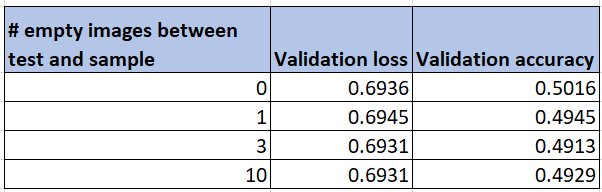